# Pneumonia Detection From Chest X-Rays

In this project, I will analyze data from the NIH Chest X-ray Dataset and train a CNN to classify a given chest x-ray for the presence or absence of pneumonia. This project will culminate in a model that aims to predict the presence of pneumonia with human radiologist-level accuracy that can be prepared for submission to the FDA for 510(k) clearance as software as a medical device. As part of the submission preparation, I will formally describe my model, the data that it was trained on, and a validation plan that meets FDA criteria.

The project will use a dataset of 112,000 chest x-rays with disease labels acquired from 30,000 patients.

## Load libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from sklearn.metrics import precision_recall_curve, f1_score, auc, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import binarize
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Load, view and clean dataset

In [2]:
## Read full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
54694,00013684_000.png,No Finding,0,13684,64,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00013684_000.png
61239,00015102_000.png,No Finding,0,15102,48,F,PA,2446,2991,0.143,0.143,NaN,/data/images_007/images/00015102_000.png
102440,00027295_002.png,No Finding,2,27295,47,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00027295_002.png


In [3]:
# Drop any unreasonable ages!
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 120]
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [4]:
## Create some extra columns in the table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Re-format multi-label column into separate columns for each label binary encoded
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # ignore empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
43672,00011246_000.png,No Finding,0,11246,40,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
60931,00015040_001.png,Atelectasis|Effusion,1,15040,48,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
25642,00006741_001.png,No Finding,1,6741,54,F,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia']==1, 'Pneumonia', 'No Pneumonia')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,No Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,No Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,No Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,No Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,No Pneumonia


## Split data into training and testing sets

In [6]:
# Total Pneumonia cases
all_xray_df['Pneumonia'].sum()

1430

So in our dataset we have:

- Pneumonia cases: 1,430 or 1.2%
- Non-Pneumonia cases: 110,674 or 98.8%

Given that we want:

- Our training set to be balanced between Pneumonia and Non-Pneumonia cases i.e. equal
- Our test set to reflect the real world proportions i.e. Pneumonia 1.2% and Non-Pneumonia 98.8%
- To split our data between training and test sets in a 80% to 20% proportion

This leads to the following training & test sets:

- Training set: 1,144 (50%) Pneumonia cases, 1,144 (50%) Non-Pneumonia cases - Total 2,288
- Test set: 286 (1.2%) Pneumonia cases, 23,547 (98.8%) Non-Pneumonia cases - Total 23,833

In [7]:
def create_splits(vargs):

    ## It's important to consider here how balanced or imbalanced we want each of those sets to be
    ## for the presence of pneumonia
    
    # Select rows with Pneumonia cases
    pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 1]
    # Select rows with No-Pneumonia cases
    no_pneumonia_df = all_xray_df[all_xray_df['Pneumonia'] == 0]
    # Split Pneumonia cases 80% - 20% between train and validation
    train_data, val_data = skl.train_test_split(pneumonia_df, test_size = 0.2)
    # Split No-Pneumonia cases into two separate groups equal size
    train_no_pneumonia_data, val_no_pneumonia_data = skl.train_test_split(no_pneumonia_df, test_size = 0.5)
    # Sample from No-Pneumonia train set to be same size as Pneumonia train set
    train_no_pneumonia_data = train_no_pneumonia_data.sample(train_data.shape[0])
    # Merge No-Pneumonia train set into train set
    train_data = pd.concat([train_data, train_no_pneumonia_data])
    # Calculate proportion required of No-Pneumonia cases for test set at 98.8%
    no_pneumonia_test_count = int((val_data.shape[0] / 1.2) * 98.8)
    # Sample from No-Pneumonia test set to be 98.8% of test set
    val_no_pneumonia_data = val_no_pneumonia_data.sample(no_pneumonia_test_count)
    # Merge No-Pneumonia test set into test set
    val_data = pd.concat([val_data, val_no_pneumonia_data])
    
    return train_data, val_data

# Create train and validation splits
train_df, valid_df = create_splits(all_xray_df)

In [8]:
# View Pneumonia vs No-Pneumonia counts for training
train_df['Pneumonia'].value_counts()

1    1144
0    1144
Name: Pneumonia, dtype: int64

In [9]:
# View Pneumonia vs No-Pneumonia counts for validation
valid_df['Pneumonia'].value_counts()

0    23547
1      286
Name: Pneumonia, dtype: int64

# Model building & training

#### Perform some image augmentation 

In [10]:
# Define image size
IMG_SIZE = (224, 224)

In [11]:
def my_image_augmentation(train=True):
    
    ## Use Keras ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## Keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    # Create image generator
    if train:
        # Training augmentations + normalisation
        idg = ImageDataGenerator(rescale=1. / 255.0, horizontal_flip = True, vertical_flip = False, height_shift_range= 0.1, 
                             width_shift_range=0.1, rotation_range=10, shear_range = 0.1, zoom_range=0.1)
    else:
        # Otherwise test set - no augmentation! just normalisation
        idg = ImageDataGenerator(rescale=1. / 255.0)
        
    return idg


def make_train_gen(df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
    # Create image generator
    idg = my_image_augmentation()

    # Apply image generator to generate more images
    train_gen = idg.flow_from_dataframe(dataframe=df, directory=None, x_col = 'path', y_col = 'pneumonia_class', 
                                  class_mode = 'binary', target_size = IMG_SIZE, batch_size = 16)

    return train_gen


def make_val_gen(df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Create image generator
    idg = my_image_augmentation(train=False)

    # Apply image generator to generate more images - large batch 10% of total validation to get enough Pneumonia
    val_gen = idg.flow_from_dataframe(dataframe=df, directory=None, x_col = 'path', y_col = 'pneumonia_class', 
                                  class_mode = 'binary', target_size = IMG_SIZE, batch_size = 2000)
    return val_gen

In [12]:
# Create training image generator
train_gen = make_train_gen(train_df)
# Create validation image generator
val_gen = make_val_gen(valid_df)

Found 2288 validated image filenames belonging to 2 classes.
Found 23833 validated image filenames belonging to 2 classes.


Let us check the distribution of key demographic values within the training & validation sets.

Text(0, 0.5, 'Number of x-ray observations')

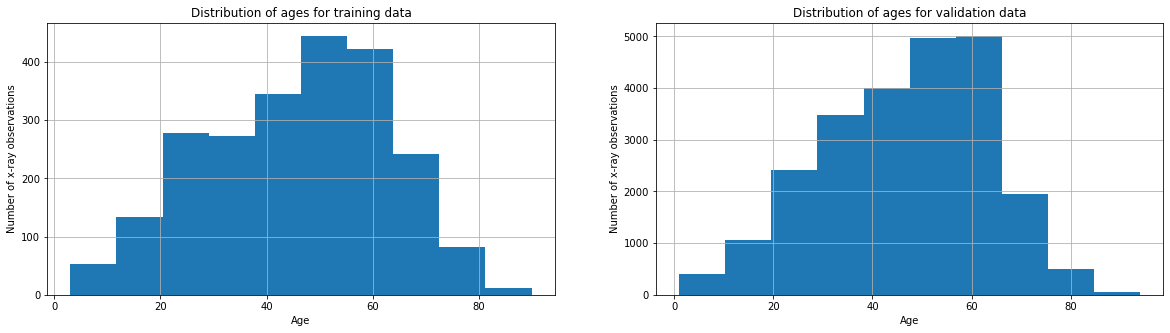

In [13]:
# Compare age distributions of training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['Patient Age'].hist(ax=axes[0],figsize=(20,5))
valid_df['Patient Age'].hist(ax=axes[1],figsize=(20,5))
axes[0].set_title('Distribution of ages for training data')
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Distribution of ages for validation data')
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Number of x-ray observations")

Text(0, 0.5, 'Number of x-ray observations')

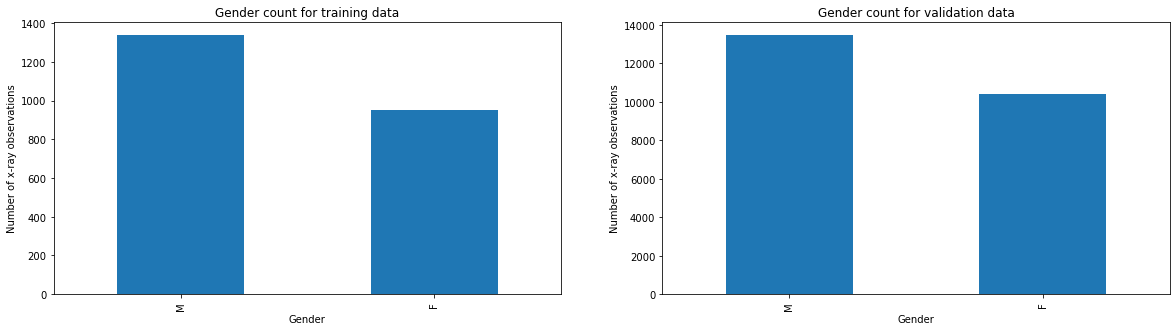

In [14]:
# Compare gender between training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['Patient Gender'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
valid_df['Patient Gender'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('Gender count for training data')
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Gender count for validation data')
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of x-ray observations")

Text(0, 0.5, 'Number of x-ray observations')

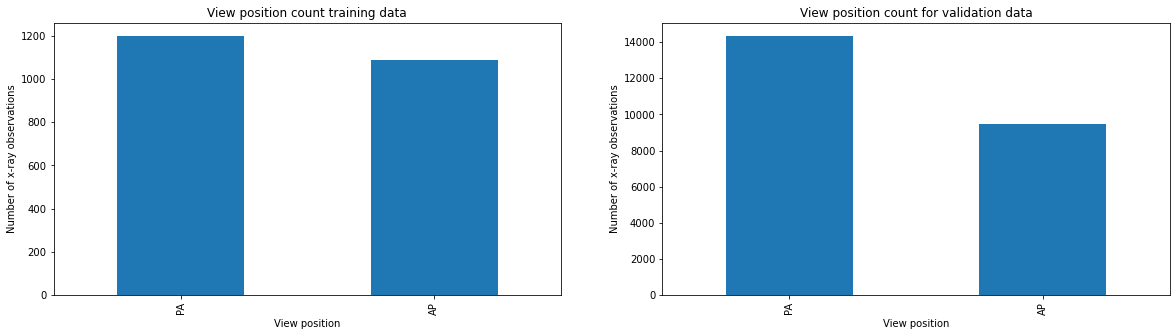

In [16]:
# Compare view position training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['View Position'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
valid_df['View Position'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('View position count training data')
axes[0].set_xlabel("View position")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('View position count for validation data')
axes[1].set_xlabel("View position")
axes[1].set_ylabel("Number of x-ray observations")

Text(0, 0.5, 'Number of x-ray observations')

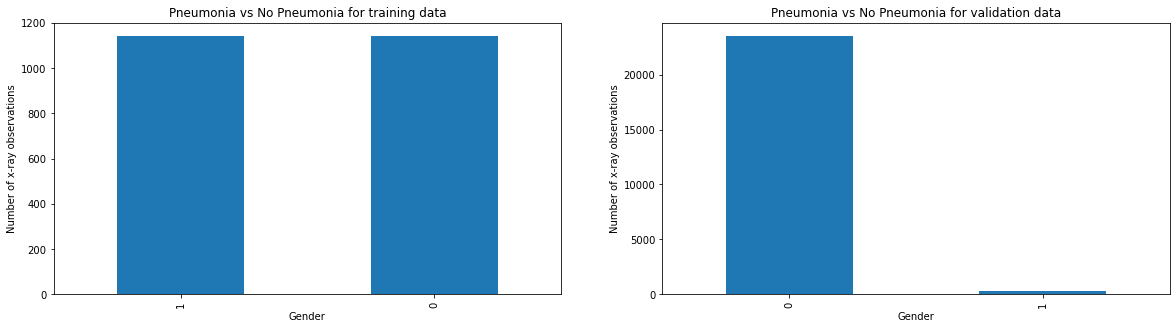

In [15]:
# Compare Pneumonia vs No Pneumonia cases between training vs validation data
fig, axes = plt.subplots(1, 2)
train_df['Pneumonia'].value_counts().plot(ax=axes[0],kind='bar',figsize=(20,5))
valid_df['Pneumonia'].value_counts().plot(ax=axes[1],kind='bar',figsize=(20,5))
axes[0].set_title('Pneumonia vs No Pneumonia for training data')
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of x-ray observations")
axes[1].set_title('Pneumonia vs No Pneumonia for validation data')
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of x-ray observations")

So these proportions of key features are as we wished and expected. The distributions of ages and proportions of gender in the training and validation are roughly the same. For the Pneumonia vs No Pneumonia cases, in our training set we have equal amounts of each case to give the model the best chance for training, while in the validation data we have a much smaller proportion of Pneumonia cases that matches the real world disease prevelance that we observed earlier here and in the EDA study.

Lets now look over more the training and validation data.

In [13]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [14]:
# Get a batch of training data
t_x, t_y = next(train_gen)
# Print mean and std dev of training batch
print('Train mean & std dev', t_x.mean(), t_x.std())

Train mean & std dev 0.54569376 0.23733293


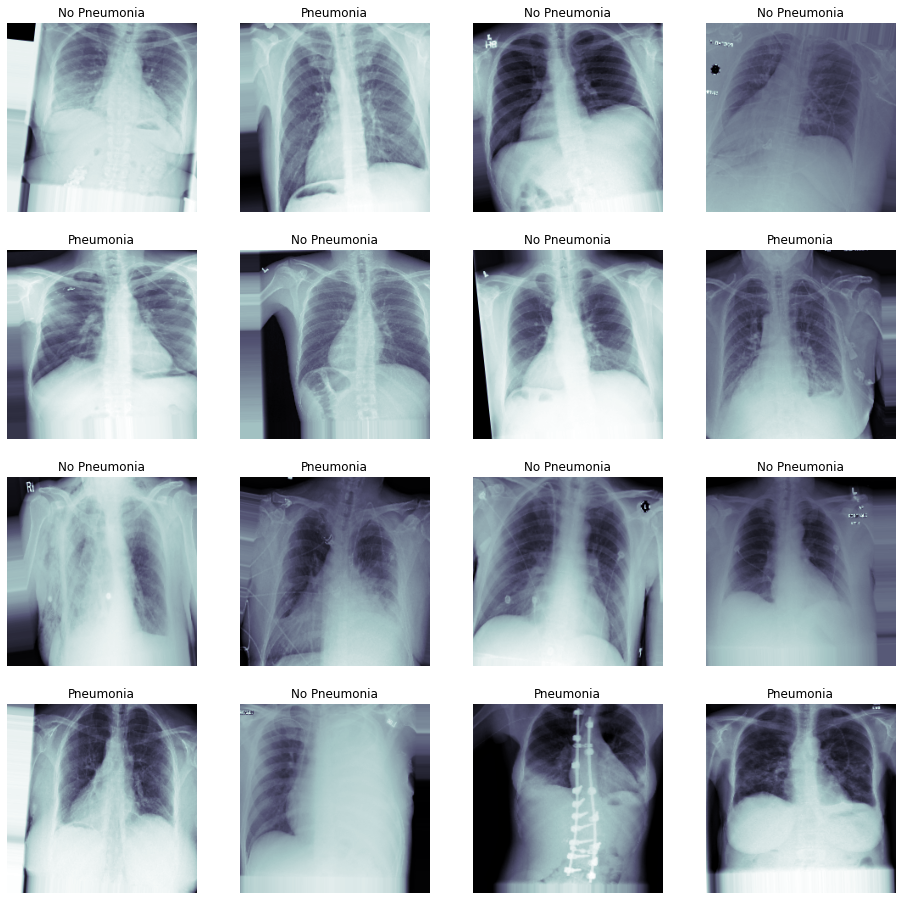

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

So these image augmentations seem reasonable.

## Build model

#### Model 1

Using a pre-trained network downloaded from Keras for fine-tuning

In [16]:
def load_pretrained_model():
    
    # Load pre-trained resnet50 model with imagenet trained weights
    model = ResNet50(include_top=True, weights='imagenet')
    
    return model


In [17]:
def build_my_model():
    
    # Load the pre-trained model
    model = load_pretrained_model()    
    model.layers.pop()
    predictions = Dense(1, activation='sigmoid')(model.layers[-1].output)
    my_model = Model(inputs=model.input, outputs=predictions)
    my_model.compile(optimizer = Adam(lr=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Print model structure
    my_model.summary()
    
    return my_model

# Build model
my_model = build_my_model()

102973440/102967424 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________

In [18]:
## Add checkpoints to model to save the 'best' version of your model by comparing it to previous epochs of training

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [19]:
## train model
history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 20, 
                           callbacks = callbacks_list)

Epoch 1/20
143/143 [==============================] - 177s 1s/step - loss: 0.7218 - binary_accuracy: 0.5800 - val_loss: 1.7579 - val_binary_accuracy: 0.0090

Epoch 00001: val_loss improved from inf to 1.75792, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
143/143 [==============================] - 136s 953ms/step - loss: 0.6603 - binary_accuracy: 0.6329 - val_loss: 0.8520 - val_binary_accuracy: 0.0120

Epoch 00002: val_loss improved from 1.75792 to 0.85198, saving model to xray_class_my_model.best.hdf5
Epoch 3/20
143/143 [==============================] - 133s 927ms/step - loss: 0.6492 - binary_accuracy: 0.6482 - val_loss: 0.6309 - val_binary_accuracy: 0.8430

Epoch 00003: val_loss improved from 0.85198 to 0.63085, saving model to xray_class_my_model.best.hdf5
Epoch 4/20
143/143 [==============================] - 133s 931ms/step - loss: 0.6207 - binary_accuracy: 0.6726 - val_loss: 0.3729 - val_binary_accuracy: 0.9910

Epoch 00004: val_loss improved from 0.63085 to 0.37292, s

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [20]:
## After training, make some predictions to assess model's overall performance
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

2000/2000 [==============================] - 24s 12ms/step


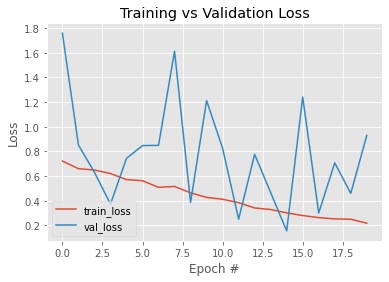

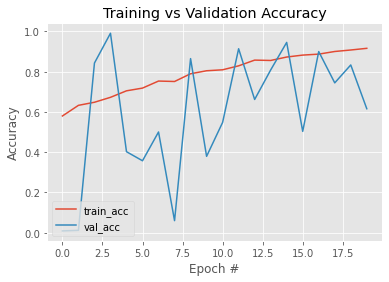

In [21]:
# Plotting the history of model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    
    plt.figure()
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    
plot_history(history)

So after trying a few different model variations I have settled for this simpler model, given the limited time for this project. This simplier model made more progress training in a shorter time, due to having fewer trainable parameters. 

Dispite this, the training is still relatively unstable even after 20 epochs, as can be seen from the highly volatile validation accuracy and loss we can see in the charts above.

**FOR A REAL MEDICAL APPLICATION, I WOULD NOT SUGGEST THE USE OF THIS PARTICULAR MODEL DUE TO THE POOR RESULTS**. 

However for this demonstration project, we will continue as if we were going to make the best of this model for an application.

Rather than let the model make fixed predictions on its own assumptions, we can get the best results from our model if we look at the raw probabilities - and then determine what the best threshold value might be to decide between the classes i.e. in our case to decide between Pneumonia and No Pneumonia cases. 

With this in mind, let us first look at a histogram of the distribution of predictions for our validation data.

(array([1217.,  235.,   97.,   88.,   80.,   60.,   43.,   36.,   18.,
          16.,   24.,   14.,   18.,   13.,   10.,   10.,    6.,    5.,
           4.,    6.]),
 array([1.4908544e-06, 4.7190338e-02, 9.4379187e-02, 1.4156803e-01,
        1.8875688e-01, 2.3594573e-01, 2.8313458e-01, 3.3032343e-01,
        3.7751228e-01, 4.2470112e-01, 4.7188997e-01, 5.1907885e-01,
        5.6626767e-01, 6.1345655e-01, 6.6064537e-01, 7.0783424e-01,
        7.5502306e-01, 8.0221194e-01, 8.4940076e-01, 8.9658964e-01,
        9.4377846e-01], dtype=float32),
 <a list of 20 Patch objects>)

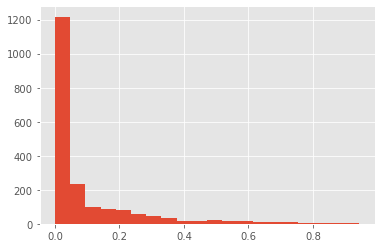

In [22]:
# Look at the distribution of the prediction probabilities
plt.hist(pred_Y, bins=20)

So we can see from this right-skewed distribution that most of the predicted values are between 0.0 and 0.2. This is to be expected of course because:

- The majority of the samples are for the prediction 0.0 i.e. 'No Pneumonia'
- From what we saw in our exploratory data analysis, the intensity profile of the Pneumonia examples can be very difficult to distinguish from other diseases i.e. from No Pneumonia cases

We might therefore estimate our optimum threshold value might be somewhere between 0.0-0.2.

We will now also look at some further metrics to help determine the optimial threshold value.

The project suggests the use of the roc-auc metric. However this is not a very good metric to use when we have very imbalanced classes, such as our use-case. See [This](https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-281cc01da0a8) article and [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432) for reasons why.

Instead I believe better metric for this would be the precison-recall curve. We will however plot both of these and compare as well as an f1-threshold plot.

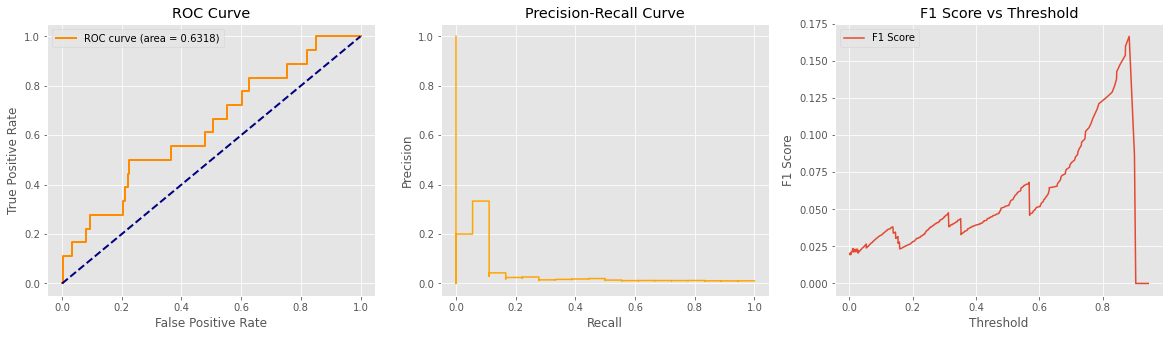

In [49]:
# Get ROC curve FPR and TPR from true labels vs score values
fpr, tpr, _ = roc_curve(valY, pred_Y)

# Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
roc_auc = auc(fpr, tpr)

# Calculate precision and recall from true labels vs score values
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Calculate f1 vs threshold scores
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)

    
# Plot charts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

lw = 2
ax1.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.title.set_text('ROC Curve')
ax1.legend(loc="upper left")
ax1.grid(True)

ax2.step(recall, precision, color='orange', where='post')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.title.set_text('Precision-Recall Curve')
ax2.grid(True)

ax3.plot(thresholds, f1_scores, label = 'F1 Score')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('F1 Score')
ax3.title.set_text('F1 Score vs Threshold')
ax3.legend(loc="upper left")
ax3.grid(True)

plt.show()

So lets us first state what in any trade off we prefer between false negatives and false positives. I would argue we would prefer to minimise false negatives over false positives - why? we are better to avoid missing any actual Pneumonia cases, even if that means we flag up more people as having Pneumonia. A healthy person being incorrectly diagnosed could get a second test or diagnosis to confirm, this is more an inconvenience. But if we fail to flag a person that actually has Pneumonia, this is far more serious. So these will be our priorities and how we define our type 1 vs type 2 errors.

Looking at the ROC curve we can see the model seems to have some skill (area above diagonal) but I am skeptical for this interpretation given the unbalanced classes and note the articles I referred to area. So Instead I would look more to the Precison-Recall curve, given we have few examples of a positive event i.e. Pneumonia, and we are less interested in the many true negatives. Here we see the curve is very low, and not far off the 'no skill' line of our imbalanced dataset which would be around the proportion of one class to another which in our validation sample of 2000 cases was 21/1971 which is around 0.01.

So we will now explore threshold values between 0.05 to 0.2 and for each of these, observe the confusion matrix, and the precison, recall and f1 scores. Given we want to prioritise minimising false negatives, **we will want to find a threshold that gives a higher value for Recall for the postive class 1.0**.

In [51]:
for threshold in [0.05, 0.1, 0.15, 0.2]:  # test 3 score thresholds which are used to determine if a class is predicted to be 0 or 1
  print("threshold:", threshold)
  print("----------")
  y_pred = [0 if y < threshold else 1 for y in pred_Y]

  # from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(valY, y_pred)

  # Pandas 'crosstab' displays a better formated confusion matrix than the one in sklearn
  cm = pd.crosstab(pd.Series(valY), pd.Series(y_pred), rownames=['Reality'], colnames=['Predicted'], margins=True)
  print(cm) 

  print()
  print("Classification report:")
  print(classification_report(valY, y_pred))
  print()
    
## Minimise false negatives so highest recall

threshold: 0.05
----------
Predicted     0    1   All
Reality                   
0.0        1231  751  1982
1.0           8   10    18
All        1239  761  2000

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.62      0.76      1982
         1.0       0.01      0.56      0.03        18

    accuracy                           0.62      2000
   macro avg       0.50      0.59      0.40      2000
weighted avg       0.98      0.62      0.76      2000


threshold: 0.1
----------
Predicted     0    1   All
Reality                   
0.0        1456  526  1982
1.0           9    9    18
All        1465  535  2000

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.73      0.84      1982
         1.0       0.02      0.50      0.03        18

    accuracy                           0.73      2000
   macro avg       0.51      0.62      0.44      2000
weighted avg       0.99      

Generally we can see that regardless of threshold value, the model struggles to do a good job classifying positive Pneumonia cases - with roughly half getting mis-classified in all cases.

We can see from the above metrics that this is a difficult threshold value to balance. While the threshold value of 0.05 gives us the highest Recall value of 0.56 for the 1.0 Pneumonia cases - and the lowest false negatives, we can see this comes at a great cost of creating 751 false positives (as seen in the confusion matrix). While we want to priortise reducing false negatives, we still care about false positives.

If we look at the next threshold value of 0.1, while it has a slightly lower recall value of 0.50 and just one more false negative, this drastically reduces the false postives from 751 down to 526 false postives. So on balance, for this model I would suggest the best threshold value, would be 0.1.

At this threshhold of 0.1, we should expect a false positive rate of 526/(526+1456) = 0.27 = 27%.

At this threshhold of 0.1, we should expect a false negative rate of 9/(9+9) = 0.5 = 50%.

## Conclusion

As I noted earlier, **I would not suggest this model has a good enough performance to be used in a real life medical application setting - it has been difficult to train this model to a high level of performance in such a limited time for a study project**. 

However that said, I have looked at how for the model I have made, how we might get the best performance from it for classifying Pneuomonia cases by finding the optimal threshold value to decide between positive and negative cases. In my judgment I have suggested that for this model, a threshold value of 0.1 gives us the best balance of results for the classifier.

In [ ]:
## Save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)